# UFO Question 

Our data science team has predicted that the Earth is going to be invaded by an alien force in the
next years. Our only hope is to replicate a device that can block all alien technology in a radius of
~300km. Sadly, the device was sold in 2004 to an anonymous buyer to protect her hometown and
we don't know how to contact her again. We know that the device has been active since 2004 in one
city in the USA, and we want to know where to start our search.
We've included a dataset called ​ufo.csv​. This dataset contains over 80,000 reports of UFO sightings
over the last century (all of them verified by the ESA). Using this dataset, try to guess the city in
which the device has been hidden.


In [442]:
# Import libraries
import pandas as pd
import numpy as np
import folium
import re
import os
from folium.plugins import HeatMap

## 1. Import data

In [443]:
df = pd.read_csv('ufo.csv')
df.head()

,Unnamed: 0,datetime,city,state,country,shape,duration,total_time,comments,date_posted,latitude,longitude,year,distance
0,0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,2004,1242.667772
1,1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,2005,1325.486319
2,2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,2008,6515.416577
3,3,10/10/1956 21:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,2004,1211.971352
4,4,10/10/1960 20:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,2004,6960.923396


## 2. Select data

In [444]:
df.drop(['Unnamed: 0', 'shape', 'duration', 'total_time',
         'comments', 'datetime','date_posted', 'distance'],
        axis=1, inplace=True)
# drop useless columns
indexNames = df[ df['country'] != 'us' ].index
df.drop(indexNames , inplace=True)
#df = df.reset_index()
df['new_index'] = [i for i in range(0,len(df['city']))]
df = df.set_index('new_index')
# drop rows where country is not "us"
# https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/
#for i in range(len(df['country'])):
#    df.datetime[i] = df.datetime[1].split()[0]
#df['datetime']= pd.to_datetime(df['datetime']) 
# keep only the mm/dd/yyyy from datetime and set it to dtype: datetime64
# https://www.geeksforgeeks.org/convert-the-column-type-from-string-to-datetime-format-in-pandas-dataframe/
df.drop('country', axis=1, inplace=True)
# drop 'country' because it's no longer useful

## 3.1 Find the city

Data split into two dataframes to be compared and discard cities that registered sightings after 2004.

In [450]:
sim = df[['city','year','latitude','longitude']]
# create new dataframe
for s in range(len(sim.city)):
    sim.city[s] = re.sub('\(.+\)', '', sim.city[s]).strip()
# replace regex " \(.+\) " and strip
sim.year = sim.year.astype(object)

sim2004 = sim[sim['year']<=2004]
sim2004['index'] = [i for i in range(0,len(sim2004['city']))]
sim2004 = sim2004.set_index('index')
lista_2004 = list(set(sim2004.city.sort_values()))

som2005 = sim[sim['year']>=2005]
som2005['index'] = [i for i in range(0,len(som2005['city']))]
som2005 = som2005.set_index('index')
lista_2005 = list(set(som2005.city.sort_values()))
# creating two lists of cities to be compared

clean_city_2004 = []
[clean_city_2004.append(lista_2004[i]) for i in range(len(lista_2004)) if (lista_2004[i] not in lista_2005)]
# making list of cities that only saw ufos prior to 2004

temp = []
[temp.append(sim.iloc[i]) for i in range(len(sim.city)) if (sim.city[i] in clean_city_2004)]
# temp list with all cities that saw ufoes before 2004, but not after 2005. as list.

s1 = pd.Series([temp[i][0] for i in range(len(temp))], name='city')
s2 = pd.Series([temp[i][1] for i in range(len(temp))], name='year')
s3 = pd.Series([temp[i][2] for i in range(len(temp))], name='latitude')
s4 = pd.Series([temp[i][3] for i in range(len(temp))], name='longitude')
# restoring order to chaos
fin_sim = pd.concat([s2, s1, s3, s4], axis=1)
fin_sim['index'] = [i for i in range(0,len(fin_sim['city']))]
fin_sim.set_index('index')
fin_sim.year = fin_sim.year.astype(object)
# if year is type int, an error ocurrs
fin_sim.drop('index', axis=1, inplace=True)

Bar graph of cities that had the most sightings up to 2004, with "Tupelo" scoring 10 sightings in total.

<AxesSubplot:>

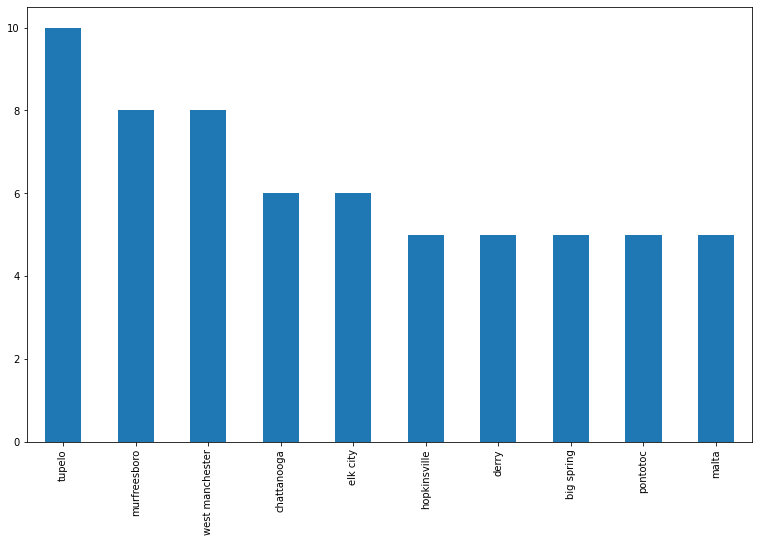

In [446]:
top10= fin_sim.city.value_counts()[:10]
top10.plot(kind='bar', figsize=(13,8))

In [447]:
lost_city = fin_sim.city.value_counts()[:1]
data = lost_city.index[0]
fin_sim.city = fin_sim.city.astype(str)
found_city = fin_sim.loc[fin_sim.city==data]
fc_lati = found_city.latitude.iloc[0]
fc_long = found_city.longitude.iloc[0]
el_dorado = found_city.city.iloc[0]

Heatmap showing all sightings over time

In [453]:
# heatmap showing all data

hmap_all = folium.Map(location=[39.153876, -94.493262], zoom_start=4, )
hm_wide_all = HeatMap( list(zip(sim.latitude.values, sim.longitude.values, sim.year.values)),
                   min_opacity=0.15,
                   max_val=1000000,
                   radius=15, blur=15, 
                   max_zoom=1, 
                 )

# https://alcidanalytics.com/p/geographic-heatmap-in-python
folium.Marker([fc_lati, fc_long],
              popup=f'<h4>Device coordinates!          </h4>Latitude: {fc_lati}\nLongitude:{fc_long}',
             tooltip=el_dorado).add_to(hmap_all)

In [454]:
hmap_all.save('hmap_all.html')

In [452]:
hmap_all.add_child(hm_wide_all)

## 3.2 conclusion

The lady who bought the anti-alien device has a high chance of being located in the city marked on the map:

    #1 What came first was getting the data.
    #2 Then came data cleaning and wrnagling.
    #3 More data wrangling after splitting the main dataframe into two lists.
       If any city continued to have UFO sightings after 2004, then it was not our city.
    #4 Further filter by count_values and visual aids like bar graph and folium map.

# 